## Gaussian Process Regression
### 1. Introduction
### 2. Data Preparation

In [3]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF 
from sklearn.model_selection import train_test_split

In [4]:
# pandas will automatically convert the 'NaN' values to np.nan
red_ball_coordinates = pd.read_csv('../data/red_ball_coordinates_128px_017.csv', delimiter=',')
red_ball_coordinates

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,NaN,NaN,NaN,NaN,NaN,NaN,52.880000,83.240000,NaN,NaN,59.0,69.5,68.666667,118.333333
1,NaN,NaN,NaN,NaN,NaN,NaN,51.041667,83.125000,NaN,NaN,NaN,NaN,68.428571,118.571429
2,NaN,NaN,NaN,NaN,125.882353,91.411765,49.833333,82.333333,NaN,NaN,NaN,NaN,68.428571,118.571429
3,NaN,NaN,NaN,NaN,124.647059,89.617647,47.416667,81.916667,NaN,NaN,NaN,NaN,68.428571,118.571429
4,40.500000,127.500000,84.500000,127.500000,123.673913,88.739130,45.909091,81.787879,NaN,NaN,NaN,NaN,68.428571,118.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,82.675000,113.975000,12.000000,72.000000,55.000000,23.750000,84.764706,66.970588,NaN,NaN,60.5,69.0,68.500000,119.500000
1869,81.043478,116.130435,12.000000,72.000000,55.000000,23.750000,82.909091,68.666667,NaN,NaN,60.5,69.0,68.500000,119.500000
1870,77.923077,119.846154,120.285714,123.333333,55.000000,23.750000,79.690476,71.452381,NaN,NaN,60.5,69.0,68.500000,119.500000
1871,79.543478,118.347826,113.777778,118.666667,55.000000,23.750000,81.096774,70.322581,NaN,NaN,60.5,69.0,68.500000,119.500000


In [5]:
xyz_coordinates = pd.read_csv('../data/positions_xyz_128px_017.csv', delimiter=',')
xyz_coordinates

,x,y,z
0,6.000000,4.000000,14.00000
1,6.000000,7.000000,14.00000
2,6.000000,7.000000,14.00000
3,6.000000,7.000000,14.00000
4,6.169909,6.993336,14.07999
...,...,...,...
1872,3.642321,5.456923,12.76173
1873,3.751164,5.628386,12.83502
1874,3.867227,5.792615,12.90916
1875,3.990135,5.948880,12.98405


In [6]:
# remove the first rows of xyz_coordinates
xyz_coordinates = xyz_coordinates.iloc[4:]
xyz_coordinates = xyz_coordinates.reset_index(drop=True)
xyz_coordinates

,x,y,z
0,6.169909,6.993336,14.07999
1,6.339272,6.973373,14.15992
2,6.507547,6.940200,14.23974
3,6.674192,6.893964,14.31939
4,6.838673,6.834871,14.39882
...,...,...,...
1868,3.642321,5.456923,12.76173
1869,3.751164,5.628386,12.83502
1870,3.867227,5.792615,12.90916
1871,3.990135,5.948880,12.98405


In [7]:
combined_data = []
# combine the two dataframes
if red_ball_coordinates.shape[0] == xyz_coordinates.shape[0]:
    combined_data = pd.concat([red_ball_coordinates, xyz_coordinates], axis=1)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,NaN,NaN,NaN,NaN,NaN,NaN,52.880000,83.240000,NaN,NaN,59.0,69.5,68.666667,118.333333,6.169909,6.993336,14.07999
1,NaN,NaN,NaN,NaN,NaN,NaN,51.041667,83.125000,NaN,NaN,NaN,NaN,68.428571,118.571429,6.339272,6.973373,14.15992
2,NaN,NaN,NaN,NaN,125.882353,91.411765,49.833333,82.333333,NaN,NaN,NaN,NaN,68.428571,118.571429,6.507547,6.940200,14.23974
3,NaN,NaN,NaN,NaN,124.647059,89.617647,47.416667,81.916667,NaN,NaN,NaN,NaN,68.428571,118.571429,6.674192,6.893964,14.31939
4,40.500000,127.500000,84.500000,127.500000,123.673913,88.739130,45.909091,81.787879,NaN,NaN,NaN,NaN,68.428571,118.571429,6.838673,6.834871,14.39882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,82.675000,113.975000,12.000000,72.000000,55.000000,23.750000,84.764706,66.970588,NaN,NaN,60.5,69.0,68.500000,119.500000,3.642321,5.456923,12.76173
1869,81.043478,116.130435,12.000000,72.000000,55.000000,23.750000,82.909091,68.666667,NaN,NaN,60.5,69.0,68.500000,119.500000,3.751164,5.628386,12.83502
1870,77.923077,119.846154,120.285714,123.333333,55.000000,23.750000,79.690476,71.452381,NaN,NaN,60.5,69.0,68.500000,119.500000,3.867227,5.792615,12.90916
1871,79.543478,118.347826,113.777778,118.666667,55.000000,23.750000,81.096774,70.322581,NaN,NaN,60.5,69.0,68.500000,119.500000,3.990135,5.948880,12.98405


### 3. Data Preprocessing

In [8]:
# split into features and target
X = combined_data.iloc[:, :14]
y = combined_data.iloc[:, 14:]

In [9]:
from sklearn.impute import SimpleImputer
# scale the features and the target
from sklearn.preprocessing import StandardScaler

#### 3.1. Impute the NaN values with mean SimpleImputer

In [10]:
imputer = SimpleImputer(strategy='mean')
X_imputed_mean = imputer.fit_transform(X)
y_imputed_mean = imputer.fit_transform(y)

#### 3.2. Impute the NaN values with median SimpleImputer

In [11]:
imputer = SimpleImputer(strategy='median')
X_imputed_median = imputer.fit_transform(X)
y_imputed_median = imputer.fit_transform(y)

### 3.3. Impute the NaN values with KNNImputer

In [12]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_imputed_knn = imputer.fit_transform(X)
y_imputed_knn = imputer.fit_transform(y)

### 4. Gaussian Process Regression

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed_mean, y_imputed_mean, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

In [14]:
X_scaled_train = scaler_X.fit_transform(X_train)
y_scaled_train = scaler_y.fit_transform(y_train)

gp.fit(X_scaled_train, y_scaled_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20)

### 5. Predictions

In [15]:
X_test_scaled = scaler_X.transform(X_test)
y_pred, sigma = gp.predict(X_test_scaled, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred)
y_pred

array([[ 7.98742301,  6.30163828, 16.67229654],
       [ 3.13400959,  3.47731422, 15.51505625],
       [ 8.57978626,  1.24433402, 16.7062787 ],
       ...,
       [ 6.82731337,  5.78110498, 15.77427896],
       [ 3.36224468,  6.90753843, 11.09085892],
       [ 6.9790179 ,  3.95698327, 14.26578964]])

### 6. Conclusion

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f'R2 Squared: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')    

R2 Squared: 0.8367711184178478
MSE: 0.7492763729023179
MAE: 0.5058366431110178


#### 6.1 Visualize the results
#### 6.1.1 3D Visualization of the predicted ball trajectory

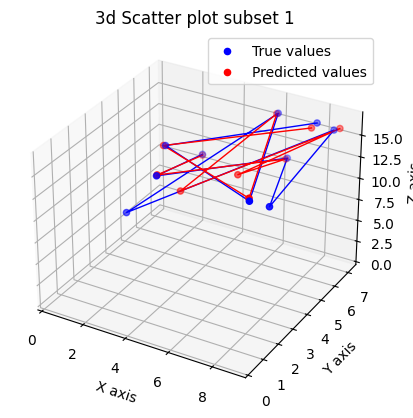

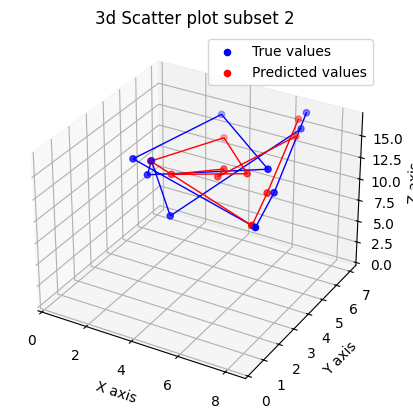

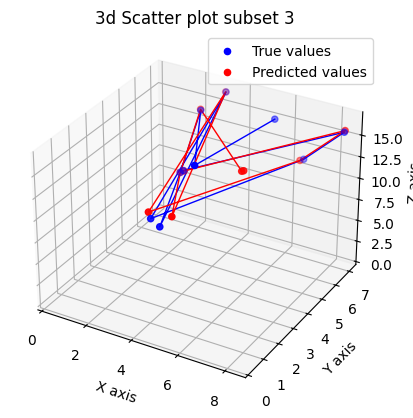

In [17]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred, '3d Scatter plot subset 1')
plot_maker_3d(y_test[100:120], y_pred[100:120], '3d Scatter plot subset 2')
plot_maker_3d(y_test[200:220], y_pred[200:220],'3d Scatter plot subset 3')

In [18]:
# Get the data for each dimension (x, y, z)
y_pred_x, y_pred_y, y_pred_z = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
sigma_x, sigma_y, sigma_z = sigma[:, 0], sigma[:, 1], sigma[:, 2]
y_test_x, y_test_y, y_test_z = y_test[:, 0], y_test[:, 1], y_test[:, 2]

#### 6.1.2 Gaussian Process In Time with Covariance For Each Dimension

In [19]:
from utils.plot_maker_gaussian_process import gaussian_process_plot
# for the x dimension
gaussian_process_plot(y_test_x[:100], y_pred_x[:100], sigma_x[:100])

ModuleNotFoundError: No module named 'plot_maker_gaussian_process'

In [ ]:
# for the y dimension
gaussian_process_plot(y_test_y[:100], y_pred_y[:100], sigma_y[:100])

In [ ]:
# for the z dimension
gaussian_process_plot(y_test_z[:100], y_pred_z[:100], sigma_z[:100])